In [1]:
import paco.processing.paco as p
import paco.processing.fullpaco as f_paco
import paco.processing.fastpaco as fastPACO

from paco.util.util import *
import cv2 as cv2
from astropy.convolution import convolve, Gaussian2DKernel, AiryDisk2DKernel
from astropy.modeling.models import Gaussian2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 


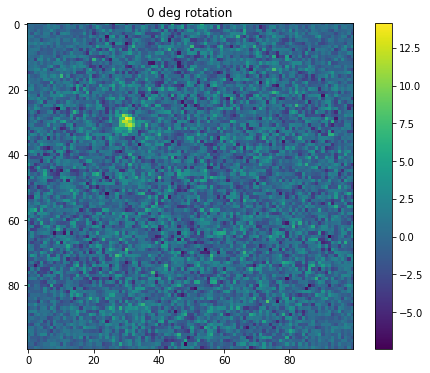

In [2]:
nFrames = 5
angles = np.linspace(0,125,nFrames)#np.array([0, 30, 45, 60, 90])
p0 = (30,30)
sigma = 1 # gaussian noise

mean = 0

images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(nFrames)]
X,Y = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))
xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
s = gaussian2d(xx,yy,5.0/np.sqrt(nFrames), 2)

#images_signal = [i + s for i in images]
rot_noise = np.array([rotateImage(images[j], angles[j]) for j in range(nFrames)])
rot_sigs = np.array([rotateImage(s, angles[j]) for j in range(nFrames)])
rot_images = np.array([rot_noise[j] + rot_sigs[j] for j in range(nFrames)])

SNR = (s*nFrames)/(np.sqrt(nFrames) * sigma)
sum_ims = np.sum([rotateImage(rot_images[j], -1.0*angles[j]) for j in range(nFrames)], axis = 0)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
im = ax.imshow(sum_ims)
ax.set_title("0 deg rotation")
fig.colorbar(im,ax = ax)




In [3]:
'''
nFrames = 125
angles = np.linspace(0,180,nFrames)
p0 = (30,30)
sigma = 1.0 # gaussian noise

mean = 0
oa = AiryDisk2DKernel(1)
ps = AiryDisk2DKernel(15)
images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]
xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
xf,yf = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))
#RHO, THETA = grid_cart_to_pol(xf,yf)

off_axis = convolve(gaussian2d(xx,yy,5.0/np.sqrt(nFrames), 2),oa)

images_signal = [i + off_axis for i in images]
rot_images = np.array([rotateImage(images_signal[j], angles[j]) for j in range(len(images_signal))])

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.imshow(rot_images[0])
ax.set_title("0 deg rotation")
'''

'\nnFrames = 125\nangles = np.linspace(0,180,nFrames)\np0 = (30,30)\nsigma = 1.0 # gaussian noise\n\nmean = 0\noa = AiryDisk2DKernel(1)\nps = AiryDisk2DKernel(15)\nimages = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]\nxx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))\nxf,yf = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))\n#RHO, THETA = grid_cart_to_pol(xf,yf)\n\noff_axis = convolve(gaussian2d(xx,yy,5.0/np.sqrt(nFrames), 2),oa)\n\nimages_signal = [i + off_axis for i in images]\nrot_images = np.array([rotateImage(images_signal[j], angles[j]) for j in range(len(images_signal))])\n\nfig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))\nax.imshow(rot_images[0])\nax.set_title("0 deg rotation")\n'

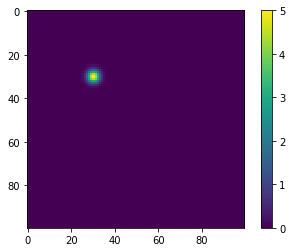

In [4]:
plt.figure()
plt.imshow(SNR)
plt.colorbar()

In [5]:
xx, yy = np.meshgrid(np.arange(-4, 5),np.arange(-4, 5))
s = gaussian2d(xx,yy,1, 2)
s = s/np.sum(s)

fp = fastPACO.FastPACO(patch_size = 49)
fp.set_image_sequence(rot_images)
phi0s = np.array([[70,70]])
a,b = fp.PACO(angles,scale = 1, model_name=psftemplate_model, params={"psf_template":s})
#a,b = fp.PACO_calc(phi0s,angles)
#a,b= fp.PACO(phi0s,angles)

Precomputing Statistics...
PSF template shape (9, 9)


ValueError: could not broadcast input array from shape (49,49) into shape (49)

In [ ]:
img = b/np.sqrt(a)
plt.imshow(img)
plt.colorbar()
